#NLP with Python: Analyzing War and Peace (Leo Tolstoy)

Many things can be accomplished through extracting information from texts. While some of tasks can be performed manually, they would require considerable effort. We can use NLP techniques to deal with this.

So I decided, that I'll show some of usage NLP with Python in this notebook

To do this I used the English version of War and Peace from [wikisource](https://en.wikisource.org/wiki/War_and_Peace_(Tolstoy)) .

Leo Tolstoy's War and Peace is a fictional work that combines chapters on history and philosophy with fictional narratives.

#Table of contents:
0. [Data Collection](#0)
1. [Data Preparation](#1)
2. [Occurring of Characters](#2)
3. [More information](#3)
4. [Most common collocations](#4)
5. [Wordcloud](#5)
6. [Conclusions](#6)

    

First, we import the necessary libraries

In [30]:
#NTLK
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.util import ngrams
from nltk.stem.wordnet import WordNetLemmatizer

#SpaCy
import spacy as sp
from spacy.lang.en import English

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
%matplotlib inline 

#Other
from wordcloud import WordCloud
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from cycler import cycler
import requests
import pandas
import re
import os

# 0.Data Collection <a name="0"></a>
I acquired the entire book, using the web scraping method. All collected data was saved in 15 different files in txt format. Each file is one War for Peace book. 

In [31]:
#Web scrapping script
book = 15
chapters = [28, 21, 19, 16, 22, 26, 13, 22, 23, 39, 34, 16, 19, 19, 20]
files = []

i = 1
temp_data = []

while i <= book:
    j = 1
    while j <= chapters[i-1]:
        BOOK = 'https://en.wikisource.org/wiki/War_and_Peace_(Tolstoy)/Book_' + str(i) + '/Chapter_' + str(j)
        html_text = requests.get(BOOK).text
        soup = BeautifulSoup(html_text, 'lxml')
        data = soup.find('div', class_='prp-pages-output').text
        temp_data += data
        j += 1

    name_of_file = 'data/book' + str(i) + '.txt'
    with open(name_of_file, 'w') as f:
        f.writelines(temp_data)
    files.append(name_of_file)
    temp_data = []
    i += 1
files 

['data/book1.txt',
 'data/book2.txt',
 'data/book3.txt',
 'data/book4.txt',
 'data/book5.txt',
 'data/book6.txt',
 'data/book7.txt',
 'data/book8.txt',
 'data/book9.txt',
 'data/book10.txt',
 'data/book11.txt',
 'data/book12.txt',
 'data/book13.txt',
 'data/book14.txt',
 'data/book15.txt']

# 1. Data Preparation <a name="1"></a>

In [32]:
open(files[0], 'r', encoding='UTF-8').read()[:1000]

'\n\u200b\nBook One: 1805\n\n\n\nCHAPTER I\n“Well, Prince, so Genoa and Lucca are now just family estates of the Buonapartes. But I warn you, if you don’t tell me that this means war, if you still try to defend the infamies and horrors perpetrated by that Antichrist—I really believe he is Antichrist—I will have nothing more to do with you and you are no longer my friend, no longer my ‘faithful slave,’ as you call yourself! But how do you do? I see I have frightened you—sit down and tell me all the news.”\nIt was in July, 1805, and the speaker was the well-known Anna Pávlovna Schérer, maid of honor and favorite of the Empress Márya Fëdorovna. With these words she greeted Prince Vasíli Kurágin, a man of high rank and importance, who was the first to arrive at her reception. Anna Pávlovna had had a cough for some days. She was, as she said, suffering from la grippe; grippe being then a new word in St. Petersburg, used only by the elite.\nAll her invitations without exception, written in F

As we can see, there are special unicode characters (e.g. \u200b) and unnecessary separators, which we need to get rid of.

The code below split the text from the loaded files into sentences and cleans it up.

In [33]:
def read_files():
    for f in files:
        temp_data = open(f, 'r', encoding='UTF-8').read()
        temp_data = [i for i in temp_data.split('\n')]
        temp_data = [i.replace('\ufeff', '') for i in temp_data if i != '' ]
        temp_data = [i.replace('\u200b', '') for i in temp_data if i != '' ]
        temp_data = [i.replace('' '', '') for i in temp_data if i != '' ]
        yield temp_data
text_sentences = list(read_files())
text_sentences[0][:5]

['Book One: 1805',
 'CHAPTER I',
 '“Well, Prince, so Genoa and Lucca are now just family estates of the Buonapartes. But I warn you, if you don’t tell me that this means war, if you still try to defend the infamies and horrors perpetrated by that Antichrist—I really believe he is Antichrist—I will have nothing more to do with you and you are no longer my friend, no longer my ‘faithful slave,’ as you call yourself! But how do you do? I see I have frightened you—sit down and tell me all the news.”',
 'It was in July, 1805, and the speaker was the well-known Anna Pávlovna Schérer, maid of honor and favorite of the Empress Márya Fëdorovna. With these words she greeted Prince Vasíli Kurágin, a man of high rank and importance, who was the first to arrive at her reception. Anna Pávlovna had had a cough for some days. She was, as she said, suffering from la grippe; grippe being then a new word in St. Petersburg, used only by the elite.',
 'All her invitations without exception, written in Fren

Out of 15 parts, the cleaned text is merged into one large.

In [34]:
text_lists = [' '.join(i) for i in text_sentences]
text = ' '.join(text_lists)
text[:1000]

'Book One: 1805 CHAPTER I “Well, Prince, so Genoa and Lucca are now just family estates of the Buonapartes. But I warn you, if you don’t tell me that this means war, if you still try to defend the infamies and horrors perpetrated by that Antichrist—I really believe he is Antichrist—I will have nothing more to do with you and you are no longer my friend, no longer my ‘faithful slave,’ as you call yourself! But how do you do? I see I have frightened you—sit down and tell me all the news.” It was in July, 1805, and the speaker was the well-known Anna Pávlovna Schérer, maid of honor and favorite of the Empress Márya Fëdorovna. With these words she greeted Prince Vasíli Kurágin, a man of high rank and importance, who was the first to arrive at her reception. Anna Pávlovna had had a cough for some days. She was, as she said, suffering from la grippe; grippe being then a new word in St. Petersburg, used only by the elite. All her invitations without exception, written in French, and delivered

We need to tokenize and parse the text.
I used two methods i.e. nlp and nltk.

In [35]:
nlp = sp.load('en_core_web_sm')
nlp.max_length = 2953811
nlp_text = nlp(text)

In [36]:
tokenizer = RegexpTokenizer("[\w']+")
text_tokens = tokenizer.tokenize(text)

stop_words = set(stopwords.words('english'))
stop_words.add('said')
stop_words.add('The')
stop_words.add('I')

filtered_sentence = [w for w in text_tokens if not w.lower() in stop_words ]
  
filtered_sentence = []
  
for w in text_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
text_tokens = filtered_sentence
text_nltk = Text(text_tokens)

# 2. Occurring of Characters <a name="2"></a>
Let's try to find the Characters that are mentioned the most in the text.

I used two example methods to do this:
- Using the spaCy to find characters that library considers to be person,
- Finding the most repeated words from the list of tokens.

In [37]:
def character_occurences(condition = 'NULL'):
    if condition == 'PERSON':
        characters = Counter()
        for ent in nlp_text.ents:
            if ent.label_ == condition:
                characters[ent.lemma_] += 1
        return characters.most_common()
    
    if condition == 'COUNTS':
        counts = Counter(text_tokens)
        return counts.most_common()    

In [38]:
print('spaCy method:')
print(character_occurences('PERSON')[:10])

spaCy method:
[('Pierre', 1765), ('Mary', 492), ('Kutúzov', 440), ('Nicholas', 409), ('Sónya', 406), ('Andrew', 403), ('Prince Andrew', 359), ('Dólokhov', 317), ('Pétya', 247), ('Anna Mikháylovna', 115)]


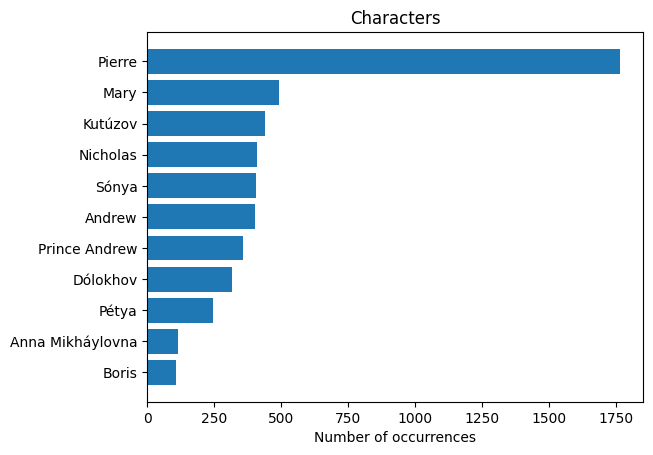

In [39]:
name_spacy = []
amount = []
i = 0
while i <= 10:
    name_spacy.append(character_occurences('PERSON')[i][0])
    amount.append(character_occurences('PERSON')[i][1])
    i += 1

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(name_spacy , amount, align='center')
ax.invert_yaxis()
ax.set_xlabel('Number of occurrences')
ax.set_title('Characters')

plt.show()


In [40]:
print('\n', 'Counts.')
print(character_occurences('COUNTS')[:10])


 Counts.
[('He', 1730), ('one', 1729), ('Pierre', 1705), ('Prince', 1562), ('would', 1228), ('Andrew', 1050), ('could', 1045), ('But', 1006), ('And', 994), ('Natásha', 971)]


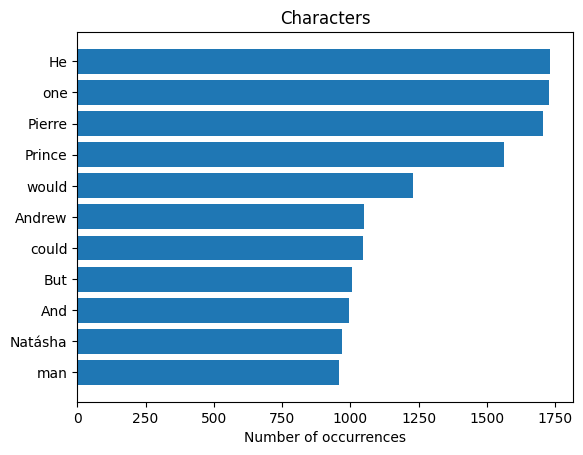

In [41]:
name = []
amount = []
i = 0
while i <= 10:
    name.append(character_occurences('COUNTS')[i][0])
    amount.append(character_occurences('COUNTS')[i][1])
    i += 1

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(name, amount, align='center')
ax.invert_yaxis()
ax.set_xlabel('Number of occurrences')
ax.set_title('Characters')

plt.show()

As we can see, the spaCy method is much better. 
However, this does not mean that this method is without problems, we have only listed the top 10 results.

NLTK also allows you to create a graph showing the occurrence of given words in specific places in the text.

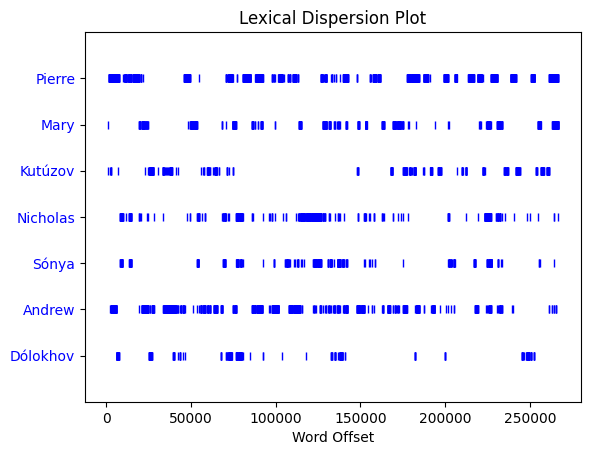

In [42]:
text_nltk.dispersion_plot(['Pierre', 'Mary', 'Kutúzov', 'Nicholas', 'Sónya', 'Andrew', 'Dólokhov'])

# 3.More information <a name="3"></a>
There are even more methods for obtaining various information than those presented above.
For example we can also obtain information, with which words the characters are described

In [43]:
def get_adjectives(doc, character_lemma):
    adjectives = []
    for ent in nlp_text.ents:
        if ent.lemma_ == character_lemma:
            for token in ent.subtree:
                if token.dep_ == 'amod':
                    adjectives.append(token.lemma_)
    
    for ent in nlp_text.ents:
        if ent.lemma_ == character_lemma:
            if ent.root.dep_ == 'nsubj':
                for child in ent.root.head.children:
                    if child.dep_ == 'acomp':
                        adjectives.append(child.lemma_)
    
    return adjectives

print("For Pierre:")
print(get_adjectives(nlp_text, 'Pierre')[:10])
print("For Andrew:")
print(get_adjectives(nlp_text, 'Andrew')[:10])

For Pierre:
['more', 'such', 'absent', 'massive', 'noticeable', 'downcast', 'gentle', 'assented', 'patronize', 'illegitimate']
For Andrew:
['rapid', 'young', 'little', 'beaming', 'ecstatic', 'renew', 'bright', 'interested', 'ill', 'silent']


We can also find the most common parts of speech.

In [44]:
tag_list = ['PROPN', 'ADJ', 'ADP', 'PRON', 'ADV', 'NOUN', 'VERB']
for i in tag_list:
    words = [token.lemma_ for token in nlp_text if token.pos_ == i and token.lemma_ not in stop_words]
    words_count = Counter(words)
    print(i, words_count.most_common(10))

PROPN [('Pierre', 1835), ('Prince', 1562), ('Andrew', 1132), ('Natásha', 1059), ('Moscow', 700), ('Rostóv', 693), ('Emperor', 614), ('Mary', 587), ('Princess', 574), ('Napoleon', 521)]
ADJ [('old', 781), ('little', 501), ('good', 490), ('young', 464), ('whole', 448), ('first', 418), ('french', 386), ('russian', 384), ('great', 308), ('last', 286)]
ADP [('without', 595), ('like', 537), ('toward', 274), ('behind', 236), ('among', 207), ('along', 199), ('beside', 176), ('near', 149), ('around', 121), ('across', 113)]
PRON [('something', 567), ('nothing', 446), ('everything', 383), ('anything', 260), ('one', 223), ('everyone', 210), ('another', 195), ('anyone', 176), ('someone', 128), ('everybody', 110)]
ADV [('still', 639), ('away', 588), ('even', 458), ('suddenly', 404), ('always', 391), ('long', 389), ('back', 369), ('well', 365), ('never', 361), ('evidently', 331)]
NOUN [('man', 1732), ('face', 999), ('time', 961), ('eye', 845), ('room', 785), ('hand', 748), ('day', 725), ('army', 666)

We can also find out who is being described by certain words.

In [45]:
counter = Counter()
word_list = ['say', 'go', 'see']

for ent in nlp_text.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ in word_list:
        counter[ent.text] += 1

print(counter.most_common(30)) 

[('Pierre', 211), ('Prince Andrew', 108), ('Nicholas', 46), ('Sónya', 41), ('Dólokhov', 40), ('Mary', 33), ('Princess Mary', 33), ('Andrew', 29), ('Kutúzov', 22), ('Anna Mikháylovna', 22), ('Denísov', 21), ('Pétya', 20), ('Anna Pávlovna', 18), ('Berg', 16), ('Nesvítski', 15), ('Prince Vasíli', 12), ('Márya Dmítrievna', 11), ('Mademoiselle Bourienne', 11), ('Boris', 11), ('Rostóv', 10), ('Bilíbin', 8), ('Rostov', 8), ('Hélène', 8), ('Véra', 7), ('Anatole', 6), ('Tit', 6), ('Karatáev', 6), ('Kutuzov', 5), ('Zherkóv', 5), ('Lavrúshka', 5)]


# 4. Most common collocations <a name="4"></a>
With nltk, we can also find the most common collocations

In [46]:
n_grams = ngrams(text_tokens,2)
Counter(n_grams).most_common(10)

[(('Prince', 'Andrew'), 990),
 (('Princess', 'Mary'), 466),
 (('one', 'another'), 188),
 (('Prince', 'Vasíli'), 171),
 (('drawing', 'room'), 150),
 (('old', 'man'), 148),
 (('commander', 'chief'), 124),
 (('Anna', 'Mikháylovna'), 121),
 (('Anna', 'Pávlovna'), 120),
 (('long', 'time'), 110)]

In [47]:
n_grams = ngrams(text_tokens,3)
Counter(n_grams).most_common(10)

[(('aide', 'de', 'camp'), 44),
 (('thought', 'Prince', 'Andrew'), 26),
 (('Prince', 'Andrew', 'went'), 24),
 (('replied', 'Prince', 'Andrew'), 18),
 (('Barclay', 'de', 'Tolly'), 17),
 (('aides', 'de', 'camp'), 16),
 (('Prince', 'Andrew', 'looked'), 14),
 (('asked', 'Prince', 'Andrew'), 14),
 (('wide', 'open', 'eyes'), 14),
 (('thought', 'Princess', 'Mary'), 14)]

In [48]:
n_grams = ngrams(text_tokens,4)
Counter(n_grams).most_common(10)

[(('remained', 'silent', 'long', 'time'), 5),
 (('get', 'away', 'quickly', 'possible'), 5),
 (('Count', 'Cyril', 'Vladímirovich', 'Bezúkhov'), 4),
 (('Prince', 'Andrew', 'Princess', 'Mary'), 4),
 (('An', 'aide', 'de', 'camp'), 4),
 (('old', 'prince', 'Princess', 'Mary'), 4),
 (('Shevárdino', 'Redoubt', 'left', 'flank'), 4),
 (('Prince', 'Andrew', 'entered', 'room'), 3),
 (('Prince', 'Andrew', 'shrugged', 'shoulders'), 3),
 (('long', 'time', 'Pierre', 'could'), 3)]

In [49]:
n_grams = ngrams(text_tokens,5)
Counter(n_grams).most_common(10)

[(('As', "'twas", 'growing', 'dark', 'last'), 3),
 (("'twas", 'growing', 'dark', 'last', 'night'), 3),
 (('make', 'peace', 'long', 'single', 'armed'), 3),
 (('Shevárdino', 'Redoubt', 'left', 'flank', 'position'), 3),
 (('shall', 'look', 'forward', 'much', 'return'), 3),
 (('Mamma', 'What', 'sweets', 'going', 'Natásha'), 2),
 (('Prince', 'Vasíli', 'eldest', 'princess', 'sitting'), 2),
 (('figure', 'old', 'man', 'white', 'dressing'), 2),
 (('old', 'man', 'white', 'dressing', 'gown'), 2),
 (('uniform', 'worn', 'long', 'time', 'went'), 2)]

# 5. Wordcloud <a name="5"></a>
Wordcloud shows the popularity of words or phrases by making the most frequently used words appear larger or bolder compared with the other words around them.

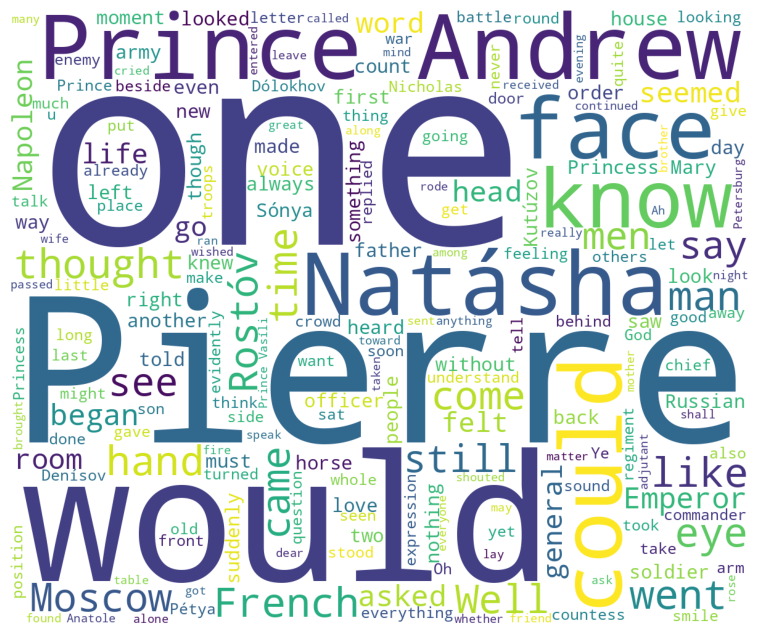

In [50]:
wordcloud = WordCloud(max_font_size=None, stopwords=stop_words, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 6.Conclusions <a name="6"></a>

In addition to helping resolve ambiguity in language, NLP contributes useful numeric structure to data for downstream processing.